In [1]:
from scipy.stats import rankdata

In [2]:
from srcfanova.confspace_utils import get_configspace, integer_encode_dataframe


import itertools as it
from collections import OrderedDict

import ConfigSpace
import numpy as np
import pandas as pd
import pyrfr.regression as reg
import pyrfr.util
from ConfigSpace.hyperparameters import CategoricalHyperparameter, UniformFloatHyperparameter, \
    NumericalHyperparameter, Constant, OrdinalHyperparameter

from surrogate import fANOVA_surrogate

In [3]:
dataf = pd.read_csv("./results_hyper.csv", sep=",")
task_ids = sorted(dataf["task_id"].unique())

#del dataf["task_id"]

measure = "val_binary_accuracy"


# make sure data is numerical and in right order for configspace
config_space = get_configspace(bool(1))
cs_params = config_space.get_hyperparameter_names()

original_df = dataf.loc[:, [cs_params[i] for i in range(len(cs_params))]]

data = dataf.loc[:, [cs_params[i] for i in range(len(cs_params))]]
data = integer_encode_dataframe(data, config_space)
data["task_id"] = dataf.task_id
data[measure] = dataf[measure]

# Data models

In [4]:
model_per_task = {}
n_trees= 128
for t_idx, task_id in enumerate(task_ids):
    
    model_per_task[task_id] = None
    data_task = data[data["task_id"] == task_id]
    del data_task["task_id"]

    y_data = data_task[measure].values
    X_data = data_task.copy()
    del X_data[measure]
    
    model_per_task[task_id] = fANOVA_surrogate(X=X_data, Y=y_data, n_trees=n_trees, seed=t_idx)

# Random Search

Functions in the cell below are to create a configspace with a hyperparameter value being fixed for the verification experiment

In [6]:
from typing import Union, Iterable
import numpy as np

import ConfigSpace
from ConfigSpace.configuration_space import ConfigurationSpace
from ConfigSpace.hyperparameters import (
    Constant,
    CategoricalHyperparameter,
    UniformIntegerHyperparameter,
    UniformFloatHyperparameter,
    NumericalHyperparameter,
)

Nvalues_grid = 10
Nvalues_depth = 10

def get_values_for_hyperparam_to_fix(
    hyperparam: object,
) -> Union[float, str, bool, int]:

    list_values = []
    if isinstance(hyperparam, NumericalHyperparameter):
        list_values = np.linspace(hyperparam.lower, hyperparam.upper, Nvalues_grid)
        if isinstance(hyperparam, UniformIntegerHyperparameter):
            list_values = [int(s) for s in list_values]
            if len(list_values) > Nvalues_depth:
                list_values = list_values[::2]
    elif isinstance(hyperparam, CategoricalHyperparameter):
        list_values = hyperparam.choices

    return list_values

def get_configspace_fixed(hyperparam_to_fix_index: int, value_to_fix_index: int = -1):

    cs = ConfigurationSpace()

    depth = UniformIntegerHyperparameter(
        name="depth", lower=1, upper=10, default_value=1
    )

    is_data_encoding_hardware_efficient = CategoricalHyperparameter(
        name="is_data_encoding_hardware_efficient",
        choices=[True, False],
        default_value=True,
    )

    have_less_rotations = CategoricalHyperparameter(
        name="have_less_rotations", choices=[True, False], default_value=True
    )

    map_type = CategoricalHyperparameter(
        name="map_type", choices=["ring", "full", "pairs"], default_value="ring"
    )
    entangler_operation = CategoricalHyperparameter(
        name="entangler_operation", choices=["cz", "sqiswap"], default_value="cz"
    )

    use_reuploading = CategoricalHyperparameter(
        name="use_reuploading", choices=[True, False], default_value=False
    )

    output_circuit = CategoricalHyperparameter(
        name="output_circuit",
        choices=["2Z", "mZ"],
        default_value="2Z",
    )

    input_activation_function = CategoricalHyperparameter(
        name="input_activation_function",
        choices=["linear", "tanh"],
        default_value="linear",
    )

    learning_rate = UniformFloatHyperparameter(
        name="learning_rate",
        lower=0.0001,
        upper=0.5,
        default_value=0.0001,
        log=True,
    )

    batchsize = CategoricalHyperparameter(
        name="batchsize", choices=[16, 32, 64], default_value=32
    )


    list_hparams = [
        batchsize,
        depth,
        entangler_operation,
        have_less_rotations,
        input_activation_function,
        is_data_encoding_hardware_efficient,
        learning_rate,
        map_type,
        output_circuit,
        use_reuploading,
    ]
#     range_values_hparam = get_values_for_hyperparam_to_fix(
#         list_hparams[hyperparam_to_fix_index]
#     )
#     if value_to_fix_index == -1:
#         return range_values_hparam

#     value_to_fix = range_values_hparam[value_to_fix_index]
#     del list_hparams[hyperparam_to_fix_index] 
    cs.add_hyperparameters(list_hparams)
    
    return cs, value_to_fix

# Run surrogates

Doing 15 simulated random search of 500 iteration/models on which surrogate are applied to get potential perfs.

In [7]:
perfs_surrogates = {}
nruns = 500

npaths = 15


for p in range(npaths):
    perfs_surrogates[p] = []
    for t_idx, task_id in enumerate(task_ids):
        perfs_surrogates[p].append([])
        for fixed_param_idx, fixed_param in enumerate([cs_params[i] for i in range(len(cs_params))]):
            perfs_surrogates[p][t_idx].append([])
            for fixedval in range(len(get_values_for_hyperparam_to_fix(config_space[fixed_param]))):
                perfs_surrogates[p][t_idx][fixed_param_idx].append(np.zeros(nruns))
                    
seed_nb = 0

for fixed_param_idx, fixed_param in enumerate([cs_params[i] for i in range(len(cs_params))]):
    for fixedval in range(len(get_values_for_hyperparam_to_fix(config_space[fixed_param]))):
        cs_param_fixed, fixedval_cs = get_configspace_fixed(fixed_param_idx, fixedval)
        for p in range(npaths):
            
            cs_param_fixed.seed(seed_nb)
            seed_nb += 1
            datafake_df = pd.DataFrame(cs_param_fixed.sample_configuration(nruns))
            datafake_df[fixed_param] = fixedval_cs
            datafake_df = datafake_df.loc[:, [cs_params[i] for i in range(len(cs_params))]]
            datafake_df_int_encoded = integer_encode_dataframe(datafake_df, config_space)
            #datafake_df_int_encoded = datafake_df_int_encoded.to_numpy()
            for t_idx, task_id in enumerate(task_ids):    

                preds = model_per_task[task_id].predict(datafake_df_int_encoded).copy()
                preds_max = [preds[0]] + [max(preds[:i]) for i in range(1,nruns)]
                perfs_surrogates[p][t_idx][fixed_param_idx][fixedval] += np.array(preds_max)


## Ranking

In [8]:
perfs_surrogates_ranks = {}

for p in range(npaths):
    perfs_surrogates_ranks[p] = []
    for t_idx, task_id in enumerate(task_ids):
        perfs_surrogates_ranks[p].append([])
        for fixed_param_idx, fixed_param in enumerate([cs_params[i] for i in range(len(cs_params))]):
            perfs_surrogates_ranks[p][t_idx].append(np.zeros(nruns))

for p in range(npaths):        
    for t_idx, task_id in enumerate(task_ids):
        for fixed_param_idx, fixed_param in enumerate([cs_params[i] for i in range(len(cs_params))]):

            nb_val_fixed = len(get_values_for_hyperparam_to_fix(config_space[fixed_param]))
            for fixedval in range(nb_val_fixed):
                perfs_surrogates_ranks[p][t_idx][fixed_param_idx] += perfs_surrogates[p][t_idx][fixed_param_idx][fixedval]

            perfs_surrogates_ranks[p][t_idx][fixed_param_idx] /= nb_val_fixed
    

In [9]:

perfs_surrogates_ranks_val = []
exclude = [9971, 10101]
#exclude = []

for p in range(npaths):
    perfs_surrogates_ranks_val.append([])
    for t_idx, task_id in enumerate(task_ids):
        if task_id not in exclude:
            perfs_surrogates_ranks_val[p].append(10 - rankdata(np.column_stack([perfs_surrogates_ranks[p][t_idx][fixed_param_idx] for fixed_param_idx, fixed_param in enumerate([cs_params[i] for i in range(len(cs_params))])]), axis=1, method='ordinal'))


In [10]:
np.array(perfs_surrogates_ranks_val).shape

(15, 5, 500, 10)

In [11]:
data_ranks = pd.DataFrame(np.array(perfs_surrogates_ranks_val).reshape((-1,nruns,10)).mean(axis=0), columns = cs_params)

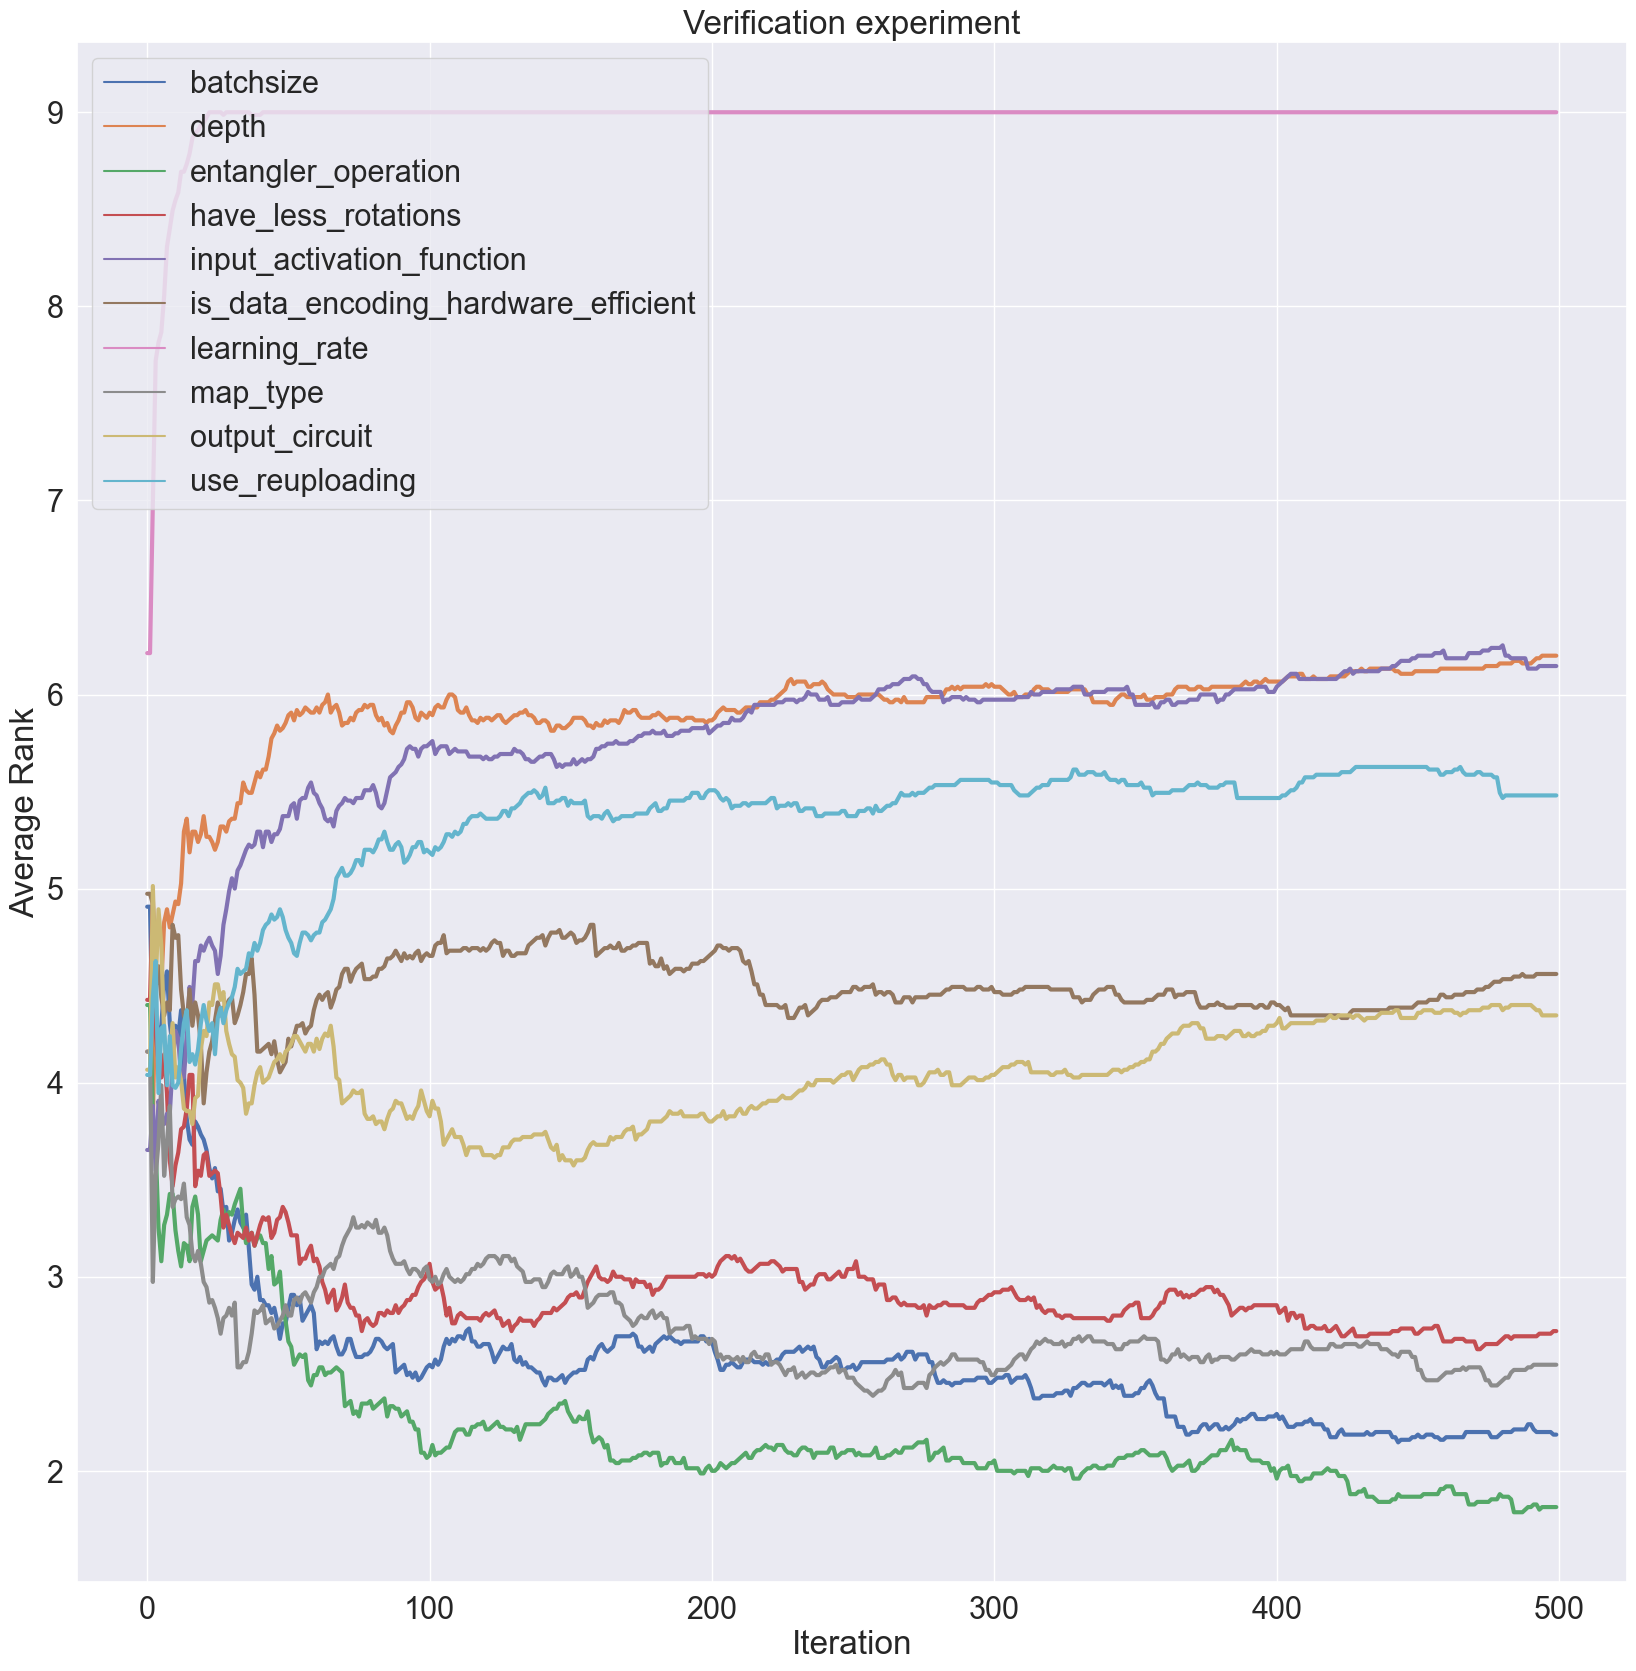

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(20,20)})
sns.set(font_scale = 2)
rollnb = 100
#g = sns.lineplot(data=data_ranks.rolling(rollnb).mean(), linewidth=3, linestyle='-')
g = sns.lineplot(data=data_ranks, linewidth=3)
for lineidx, l in enumerate(g.lines):
    g.lines[lineidx].set_linestyle('-')

for lineidx, l in enumerate(g.legend().get_lines()): 
    l.set_linestyle('-')
#g.set(yscale="log")
#g.set(xscale="log")
g.set(xlabel="Iteration")
g.set(ylabel="Average Rank")
g.set(title="Verification experiment")
plt.show()